# Project 1
## MATH 189 Winter 2021, Group 2

Members:
- Kasen Teoh
- Chung En Pan
- Nathan Fallahi
- Shaheen Daneshvar
- Parsa Ganjooi
- Eamon Jarrett-Mann

# Introduction

Smoking, nowadays, is known to be detrimental to health. Today, we can see many effects of smoking that were not noticeable back in the day.  However, in the early part of the twentieth century, smoking was considered to be a common part of life. In the twentieth century, there was little evidence that suggested smoking posed dangers to pregnant women and their unborn children. In this project, we aim to study the weight difference between babies born to mothers who smoked during pregnancy and those who did not smoke and whether this difference influences the health of the baby. In the 1990s, the surgeon general issued a statement tying the smoking of pregnant women to fetal injury, premature birth, and low birth weight. At the time, 15% of pregnant women continued to smoke despite the warning. Hence this statistical analysis is crucial to providing evidence of whether there truly is a correlation between the two.

In our analysis we aim to ask: What is the difference in weight between babies born to mothers who smoked during pregnancy and those who did not? Is this difference important to the health of the baby? To answer these questions we break our analysis into smaller parts:
1. Numerically summarize the two distributions of birth weight for babies born to women who smoked and did not smoke while pregnant.
2. Utilize graphical tools to compare the two distributions of birth weight.
3. Compare the frequency, or incidence, of the two groups and state how reliable our estimations are. 
4. Assess and compare the three types of comparisons, numerical, graphical, and incidence.
5. Summarize your findings and relate them to other studies.

Following our big question, we also wish to further analyze what other factors may have an influence in a baby’s birth weight. Factors of interest include how long the mother has quit smoking, the annual income of both parents, and the race of only the mother.


# Data

Using a combination of the babies..txt and babies23.txt data sets, we have a total of 10 variables and 1236 observations. The data consist of all the pregnancies that occurred between 1960 and 1967 among women and enrolled in the Kaiser Health Plan in Oakland, California. The pregnant women in the dataset all obtained prenatal care in the San Francisco Area and delivered in the Kaiser Permanente hospital across Northern California. To eliminate the possible confounding variable, the babies are limited to be boys only, single birth (block), and live at least 28 days (cause of initial deaths are generally uncertain ). This helps get rid of the confounding variable of gender and that of babies dying before 28 days. After cleaning and grouping, the “Smoking ” women consists of 742 observations and “Non- Smoking” women consists of 484 observations. Some of the investigations used the dataset with more features, we included inc, race and time from the babies23.txt dataset, which represent parental income, mother’s race and length of time since quitting smoking respectively. Each of these additional features only occured for some of the observations, limiting the sample size we have to work with for our independent questions.

In [12]:
# Imports and setup
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from statsmodels.stats import weightstats as stests
from statsmodels.stats.proportion import proportion_confint
from statsmodels.graphics.gofplots import qqplot_2samples
import patsy
import statsmodels.api as sm
import scipy 
sns.set()
sns.set_context('talk')
import warnings
warnings.filterwarnings("ignore")

In [13]:
# Load the data and take a sneak peak
# Note: This is the babies.txt dataset, not babies23.txt dataset which contains more variables
df = pd.read_csv('data/babies.txt', sep = '\\s+')
bdf = pd.read_csv('data/babies23.txt', sep = '\\s+')[['wt','gestation','parity','age','ht','wt.1','smoke', 'inc', 'race', 'time']]  #regular expression for varying amount of spaces
bdf = bdf.rename(columns = {'wt':'bwt', 'wt.1':'weight', 'ht':'height'})
bdf = bdf.assign(**{'race' : bdf.race.apply(lambda x: x if (x != 99 and x != 10) else np.nan)})
race_dic = {0: 0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:1, 7:2, 8:3, 9:4}
bdf = bdf.assign(**{'race' : bdf.race.apply(lambda x: x if np.isnan(x) else race_dic[int(x)])})
bdf = bdf.assign(**{'inc' : bdf.inc.apply(lambda x: x if (x != 98 and x != 99) else np.nan)})
bdf = bdf.assign(**{'time': bdf.time.apply(lambda x: x if (x != 98 and x != 99 and x != 9) else np.nan)})
df.head()

,bwt,gestation,parity,age,height,weight,smoke
0,120,284,0,27,62,100,0
1,113,282,0,33,64,135,0
2,128,279,0,28,64,115,1
3,123,999,0,36,69,190,0
4,108,282,0,23,67,125,1


The table above shows that we have a total of 1236 observations with 7 variables total. All of the variables except the column 'smoke' are discrete and the column 'smoke' is a categorical variable.

- 'bwt' is the child's birth weight in ounces (999 unknown)
- 'gestation' is the length of pregnancy in days (999 unknown)
- 'parity' is 0=first born, 9=unknown
- 'age' is the mother's age in years
- 'height' is the mother's height in inches (99 unknown)
- 'weight' is the mother's prepregnancy weight in pounds (999 unknown)
- 'smoke' is the smoking status of mother with 0=not now, 1=yes now, 9=unknown.

In [14]:
bdf.head()

,bwt,gestation,parity,age,height,weight,smoke,inc,race,time
0,120,284,1,27,62,100,0,1.0,3.0,0.0
1,113,282,2,33,64,135,0,4.0,0.0,0.0
2,128,279,1,28,64,115,1,2.0,0.0,1.0
3,123,999,2,36,69,190,3,8.0,0.0,5.0
4,108,282,1,23,67,125,1,1.0,0.0,1.0


The following table represents the data in the babies23.txt, specifically with the additional aforementioned variables we are using in our independent analysis. These are all categorical variables.
- 'inc' is the income, in 2500 dollar brackets starting at <2500 ending at 15000+
- 'race' is mother's race 0:'White', 1:'Mex', 2:'Black', 3:'Asian', 4:'Mix'
- 'time' If mother quit, how long ago? 0=never smoked, 1=still smokes, 2=during current preg, 3=within 1 yr, 4= 1 to 2 years ago, 5= 2 to 3 yr ago, 6= 3 to 4 yrs ago, 7=5 to 9yrs ago, 8=10+yrs ago, 9=quit and don't know, 98=unknown, 99=not asked

Note that some of these variables have unknown or null values.

In [15]:
print(str((df['bwt'] == 999).sum()), 'birth weight null values\n' + str((df['gestation'] == 999).sum()), 'gestation null values\n' + 
     str((df['parity'] == 9).sum()), 'parity null values\n' + str((df['height'] == 99).sum()), 'height null values\n' + 
     str((df['weight'] == 999).sum()), 'weight null values\n' + str((df['smoke'] == 9).sum()), 'smoke null values\n'
     + str(bdf['inc'].isnull().sum()), 'inc null values\n' + str(bdf['race'].isnull().sum()) + ' race null values\n' + str(bdf['time'].isnull().sum()) + ' time null values')

0 birth weight null values
13 gestation null values
0 parity null values
22 height null values
36 weight null values
10 smoke null values
124 inc null values
13 race null values
15 time null values


In [16]:
# Replacing the unknown values with NaN

df.replace({'bwt': {999: np.NaN}, 'gestation': {999: np.NaN}, 'weight': {999: np.NaN}, 
            'parity': {9: np.NaN}, 'height': {99: np.NaN}, 'smoke': {9: np.NaN},'age': {99: np.NaN}}, inplace = True)

We drop the observations which have an unknown smoking status. We drop these 10 rows because this column is directly involved in our question. 

For our independent questions, we ignore the rows with null values for the variables in question.

In [17]:
df.dropna(subset = ['smoke'], inplace = True)

# Background

Children are our future. We rely on our children to carry on our legacy. Parents constantly care for their children from the moment they are delivered. An issue originating from when the baby is still in the womb is the problem of low birth weight and preterm delivery. From previous studies, we know there is a relationship between weeks of gestation, birthweight, and perinatal mortality. In general, fewer weeks of gestation and lower birthweight result in greater perinatal mortality (Wilcox & Skjaerven 1992). Preterm delivery is defined by a baby being delivered before reaching its 37th week in the womb and babies born at term but weigh less than 5.5 pounds are considered small for their gestational age. Preterm delivery leads to low birth weight because the longer the baby develops in the womb, the heavier and longer the baby will grow. For instance, at 32 weeks, the fetus weighs around 5-5.5 pounds and is around 45 centimeters long. Then, in the final weeks, the fetus gains around 0.2 pounds a week. On average, newborns range from 45-55 centimeters in length and 5.5-8.8 pounds. 

There are many factors that may contribute to low birth weight. A study analyzing the causes of baby birth weight noted that smoking, indoor pollution, and the mother’s nutritional intake, all had an effect on the baby’s birth weight (Basel et al., 2020). One factor, in particular, a mother’s weight was analyzed noted that “observational studies have generally found direct associations between maternal body weight or weight gain during pregnancy and birth weight” (Ludwig et al., 2010). It has also been observed that “cigarette smokers weigh less and are leaner than persons of the same sex and age who never smoked” (Albanes et al., 1987). From these two studies, a possible relationship between smoking and birth weight may exist. Because those who smoke generally weigh less than their counterparts that do not smoke, and direct associations have been found between the maternal body weight and birth weight, smoking mothers would, in turn, have a lower body weight possibly contributing to low birth weight. Although there are many variables, such as the mother’s age, genetics, weight, etc, contributing to the weight of a newborn, in this study, we aim to identify the difference in birth weight among babies born to smoking and non-smoking mothers. In a study analyzing the short and long term effects of birth weight and neonatal medical complications by the University of Missouri - Columbia, babies with low birth weight are at an increased risk “for adjustment problems in late childhood, especially hyperactivity, oppositional behavior, and psychological issues” (Williams, 2008). Another study had noted that low birth weight babies are at an “increased risk for diabetes and cardiovascular disease in adulthood”  (Ludwig et al., 2010). This difference in birth weight between the two groups is important to the baby’s health because a low birth weight may constitute various health complications in the future. 

Additionally, studies have shown that race and ethnicity of the mother are correlated with different rates of infant mortality. For example, non-hispanic blacks have greater infant mortality compared to non-hispanic whites (Mathews, et al. 2003). The knowledge further adds to the importance of needing to investigate other possible factors that can influence infant mortality rates.

# Investigation (Analysis)

## Numerical Summaries 

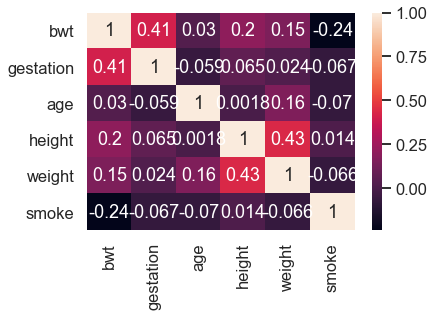

In [18]:
p = sns.heatmap(df[['bwt', 'gestation', 'age', 'height', 'weight', 'smoke']].corr(), annot = True)
plt.show()

In this above correlation heatmap, there is obvious postive correlation between the mother's height and weight, positive correlation between weeks of gestation and birthweight, and negative correlation between smoking status and birthweight.

In [19]:
no_smoke = df[df['smoke'] == 0]
no_smoke.describe()

,bwt,gestation,parity,age,height,weight,smoke
count,742.000000,733.000000,742.000000,741.000000,733.000000,725.000000,742.0
mean,123.047170,280.186903,0.261456,27.560054,64.016371,129.635862,0.0
std,17.398689,16.627607,0.439724,5.867061,2.477164,21.472064,0.0
min,55.000000,148.000000,0.000000,17.000000,56.000000,89.000000,0.0
25%,113.000000,273.000000,0.000000,23.000000,62.000000,115.000000,0.0
50%,123.000000,281.000000,0.000000,27.000000,64.000000,126.000000,0.0
75%,134.000000,289.000000,1.000000,31.000000,66.000000,140.000000,0.0
max,176.000000,353.000000,1.000000,45.000000,71.000000,250.000000,0.0


In the cell above, there are a total of 544 observations of non-smoking mothers. 

For the non-smoking mothers’ data, there are a total of 742 observations. Looking primarily at the ‘bwt’ (birth weight) column, the range of the data is from 55 to 176 ounces with a mean of 123.05 ounces and a standard deviation of 17.40 ounces. The lower and upper quantiles are 113 and 134.00 ounces, respectively. Additionally, the 0.5 quantile, the median, is 123 ounces. Because the mean and median are extremely close in value, we believe the birth weight distribution of non-smoking mothers is fairly symmetric. Continuing with the other columns, we see that the mean and median values for all columns, except for the ‘weight’, are extremely close. Hence, this leads us to believe that the distributions of all the variables, with the exception of ‘weight’, are symmetrical. The weight of non-smoking mothers has a mean of 129.64 pounds and a median of 126 pounds, meaning the distribution is possibly skewed to the right. 

In [20]:
smoke = df[df['smoke'] == 1]
smoke.describe()

,bwt,gestation,parity,age,height,weight,smoke
count,484.000000,480.000000,484.000000,483.000000,471.000000,465.000000,484.0
mean,114.109504,277.979167,0.250000,26.728778,64.091295,126.823656,1.0
std,18.098946,15.073639,0.433461,5.636917,2.619515,19.915097,0.0
min,58.000000,223.000000,0.000000,15.000000,53.000000,87.000000,1.0
25%,102.000000,271.000000,0.000000,22.000000,62.000000,112.000000,1.0
50%,115.000000,279.000000,0.000000,26.000000,64.000000,125.000000,1.0
75%,126.000000,286.000000,0.250000,30.000000,66.000000,136.000000,1.0
max,163.000000,330.000000,1.000000,43.000000,72.000000,215.000000,1.0


In the cell above, there are 484 observations of smoking mothers

For the smoking mothers’ data, there is a total of 484. Looking at the ‘bwt’ column, the range of the data is from 58 to 163 ounces with a lower and upper quantile of 102 and 126 ounces, respectively. Once again, we see that the mean and median are fairly close at 114.11 and 115 ounces and the same going for the rest of the columns. In the ‘gestation’ and ‘weight’ columns, the mean and median are slightly different by around 2 units, leading us to believe that the distributions of these two variables are skewed. However, having yet to look at the graphical summaries of the variables, we are not entirely sure. 

Immediately, we see a difference in the two groups in the ‘bwt’, ‘gestation’, and ‘weight’ columns. Comparing non-smoking to smoking mothers, the mean birth weight was 123 vs 114 ounces, the mean gestation period was 280.18 vs 277.98 days, and the mean weight was 129.64 vs 126.82 pounds. Just from the numerical summaries, we see that there, in fact, is a difference among birth weight between non-smoking and smoking mothers; however, we are unsure of whether this difference can be attributed to smoking or by random chance alone. 

In [21]:
nosmoke_temp = no_smoke.dropna()
smoke_temp = smoke.dropna()

alpha = 0.05
stat, p_b = ttest_ind((nosmoke_temp['bwt']), (smoke_temp['bwt']))
stat, p_g = ttest_ind((nosmoke_temp['gestation']), (smoke_temp['gestation']))
stat, p_h = ttest_ind((nosmoke_temp['height']), (smoke_temp['height']))
stat, p_w = ttest_ind((nosmoke_temp['weight']), (smoke_temp['weight']))
stat, p_a = ttest_ind((nosmoke_temp['age']), (smoke_temp['age']))

variables = [p_b, p_g, p_h, p_w, p_a]
conclusion = []


data = [['bwt', nosmoke_temp['bwt'].mean(), smoke_temp['bwt'].mean()],
        ['gestation', nosmoke_temp['gestation'].mean(), smoke_temp['gestation'].mean()],
       ['height', nosmoke_temp['height'].mean(), smoke_temp['height'].mean()], 
       ['weight', nosmoke_temp['weight'].mean(), smoke_temp['weight'].mean()], 
       ['age', nosmoke_temp['age'].mean(), smoke_temp['age'].mean()]]

for i in range(len(variables)): 
    data[i].append(round(variables[i], 5))
    if variables[i] > alpha:
        data[i].append('Fail to reject the null hypothesis')
    elif variables[i] < alpha:
        data[i].append('Reject the null hypothesis')

pvalues = pd.DataFrame(data, columns = ['Variable', 'Non-smoking Mean', 'Smoking Mean', 'P-value', 'Result']).set_index('Variable')

pvalues 

,Non-smoking Mean,Smoking Mean,P-value,Result
Variable,,,,
bwt,123.085315,113.819172,0.00000,Reject the null hypothesis
gestation,279.874126,277.897603,0.03896,Reject the null hypothesis
height,64.013986,64.104575,0.54901,Fail to reject the null hypothesis
weight,129.479720,126.919390,0.03891,Reject the null hypothesis
age,27.544056,26.736383,0.02022,Reject the null hypothesis


We are performing a two independent sample t-test, with alpha as 0.05, that the difference between the two means of baby birth weight is significant. 


The null hypothesis is that there is no difference between the two means for the variable in question (bwt, gestation, height, weight, and age). 


The alternative hypothesis is that there is a difference between the two means for the variable in question.


Additionally, there are three variables which have a significant difference in the means of non-smoking and smoking mothers, the gestation,  weight, and age. The variable, height, does not have a significant difference. Hence, we believe that in our data, there are four factors leading to a low birth weight, the gestation period of the baby, the age and weight of the mother, and whether or not the mother had smoked while pregnant. 


We believe that the height of the mother did not have an affect on the difference in birth weight of the baby in this particular study because in both groups, smoking and non-smoking, the difference in height is not significant, meaning the height among both groups is fairly similar. 


## Graphical Summaries and Comparisons

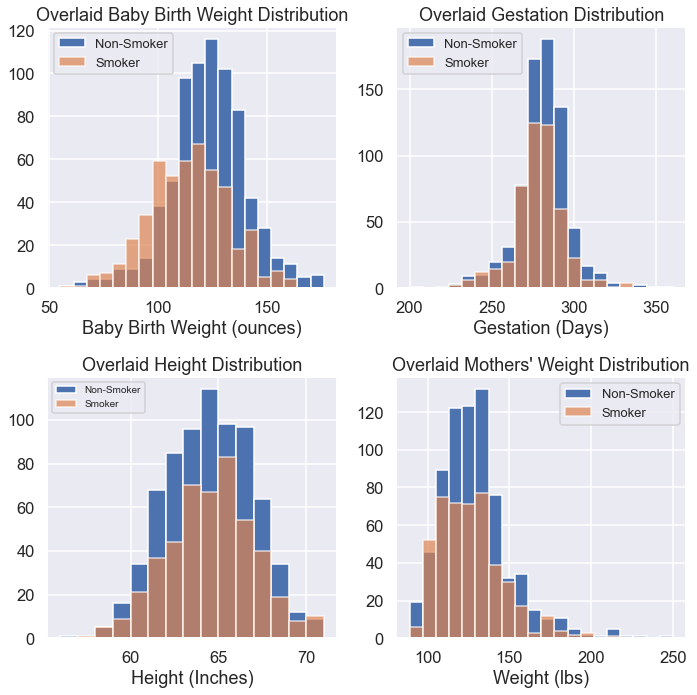

In [22]:
fig, axes = plt.subplots(2, 2, figsize = (10, 10))

# Baby Birth Weight Distribution
axes[0,0].set_title('Overlaid Baby Birth Weight Distribution')
_, binz, _ = axes[0,0].hist(no_smoke.get('bwt'), bins=20)
axes[0,0].hist(smoke.get('bwt'), alpha=0.7, bins=binz)
axes[0,0].set_xlabel('Baby Birth Weight (ounces)')
axes[0,0].legend(['Non-Smoker', 'Smoker'], prop={'size': 13}, loc = "upper left")

# Gestation Distribution
axes[0][1].set_title('Overlaid Gestation Distribution')
_, binz, _ = axes[0][1].hist(no_smoke.get('gestation'), range=[200,360], bins=20)
axes[0][1].hist(smoke.get('gestation'), alpha =.7, bins=binz)
axes[0][1].set_xlabel('Gestation (Days)')
axes[0][1].legend(['Non-Smoker', 'Smoker'], prop={'size': 13}, loc = "upper left")

# Height Distribution
axes[1][0].set_title('Overlaid Height Distribution')
_, binz, _ = axes[1][0].hist(no_smoke['height'], bins=15)
axes[1][0].hist(smoke['height'], alpha = .7, bins=binz)
axes[1][0].set_xlabel('Height (Inches)')
axes[1][0].legend(['Non-Smoker','Smoker'], prop={'size': 10}, loc = "upper left")

# Mother's Weight Distribution
axes[1][1].set_title('Overlaid Mothers\' Weight Distribution')
_, binz, _ = axes[1][1].hist(no_smoke['weight'], bins=20)
axes[1][1].hist(smoke['weight'] ,alpha = .7, bins=binz)
axes[1][1].set_xlabel('Weight (lbs)')
axes[1][1].legend(['Non-Smoker', 'Smoker'], prop={'size': 13}, loc = "upper right")

plt.tight_layout()
plt.show()

In the first histograms above (top-left), we see that the mean of birth weight in the non-smoker group is greater than that of the smoker group. Additionally, we see that both distributions are approximately normal. The range of the non-smoking group birth weight is from around 55 to 180 ounces while that of the smoking group is from aroudn 60 to 163 ounces. 

In the following histograms (top-right), we see the gestation distribution of both the non-smoking and smoking groups. We see, once again, the distribution is approximately symmetrical with the mean of the non-smoking mothers' gestation period slightly higher than that of the smoking mothers. 

In the bottom-left plot of histograms, the non-smoking distribution is unimodal with a peak at around 64 inches. The height distribution for the smoking group is unimodal and approximately normal. In both histograms, we see that the mean height of the mothers is approximately the same. 

In the last plot, we see the distribution of weight in both groups. In both histograms, it is skewed to the right. The mean of the non-smoking groups seems to be slightly greater than that of the smoking group. 

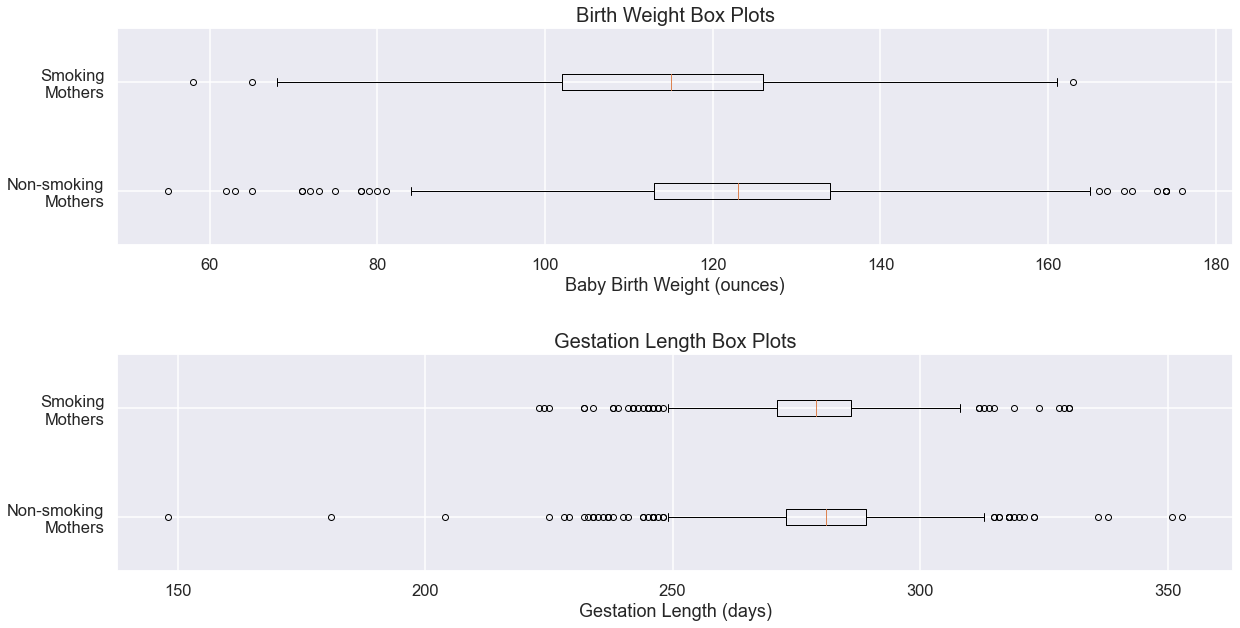

In [23]:
# Birth Weight Box Plots

fig, ax = plt.subplots(2, 1, figsize = (20, 10))

data = [no_smoke['bwt'], smoke['bwt']]
ax[0].set_title("Birth Weight Box Plots", fontsize = 20)
ax[0].boxplot(data, vert=False, labels=['Non-smoking\nMothers', 'Smoking\nMothers'])
ax[0].set_xlabel('Baby Birth Weight (ounces)')

# Gestation Box Plots
# Warning, we need to forcibly drop null values to plot a boxplot using Matplotlib.pyplot
data = [no_smoke['gestation'].dropna(), smoke['gestation'].dropna()]
ax[1].set_title("Gestation Length Box Plots", fontsize = 20)
ax[1].boxplot(data, vert=False, labels=['Non-smoking\nMothers', 'Smoking\nMothers'])
ax[1].set_xlabel('Gestation Length (days)')


plt.subplots_adjust(hspace=0.5)
plt.show()

Above, we see the box plots for both the birth weight in ounces and the gestation length in days for both groups, non-smoking and smoking mothers. In the birth weight plot, we see that the median of baby birth weight of non-smoking mothers is greater than that of the smoking mothers median. Additionally, we see that on both sides of the boxplot, that there are approximately an equal number of outliers for both groups. 


The bottom boxplot, the gestation length, we see that the gestation length for non-smoking mothers is slightly longer than smoking mothers' gestation length. Again, we see outliers on both sides of the boxplots for both groups. However, in both groups, there are a few more outliers on the to the left of the range. 


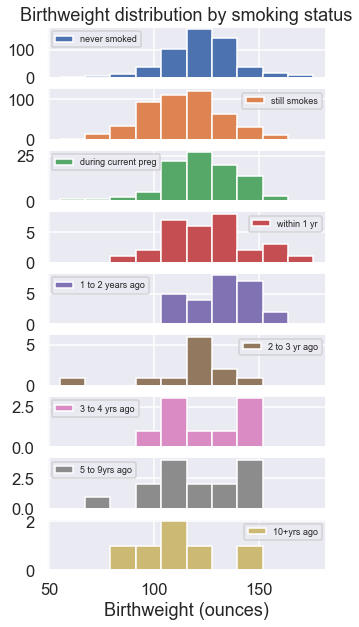

In [24]:
params = {'legend.fontsize': 9,
          'legend.handlelength': 2}
plt.rcParams.update(params)
s = bdf.groupby('time')['bwt'].apply(np.array).rename({0:'never smoked', 1:'still smokes', 2:'during current preg', 3:'within 1 yr', 4:'1 to 2 years ago', 5: '2 to 3 yr ago', 6: '3 to 4 yrs ago', 7:'5 to 9yrs ago', 8:'10+yrs ago'})
g = s.apply(lambda x:pd.Series(x)).T.plot.hist(subplots = True, figsize = (5,10))
for i in range(len(g)):
    g[i].set_ylabel(None)
g[8].set_xlabel('Birthweight (ounces)')
g[0].set_title('Birthweight distribution by smoking status')
plt.show()

These histograms show that there is a wide variety in sizes across the smoking status. For example, the highest frequency bar in the never smoked is ~100 while the highest in 10+years ago is only 2! The histograms with few occurences seem like they could represent normal distributions or (particularly 3-4 and 5-9 years ago) bimodal normal distibutions. However, it does not seem wise to draw conclusions from such small samples, as they are less likely to be representative of the population than if we had larger samples.

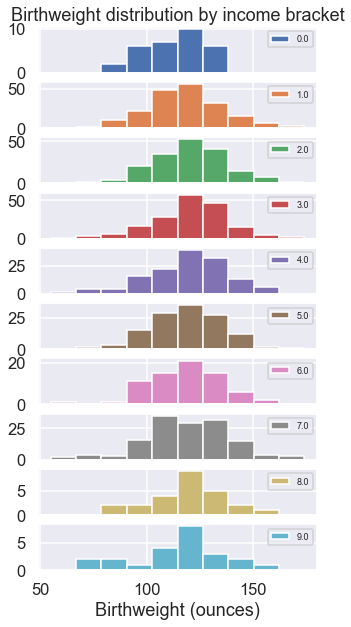

In [25]:
s = bdf.groupby('inc')['bwt'].apply(np.array)
g = s.apply(lambda x:pd.Series(x)).T.plot.hist(subplots = True, figsize = (5,10))
for i in range(len(g)):
    g[i].set_ylabel(None)
g[9].set_xlabel('Birthweight (ounces)')
g[0].set_title('Birthweight distribution by income bracket')
plt.show()

These histograms look largely the same. It is obvious that lower incomes appear more in the dataset, but there does not appear to be significant variation in birth weight accross the incomes represented here.

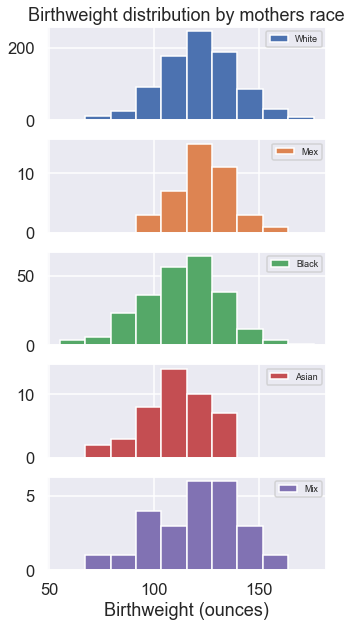

In [26]:
s = bdf.groupby('race')['bwt'].apply(np.array).rename({0:'White', 1:'Mex', 2:'Black', 3:'Asian', 4:'Mix'})
ax = s.apply(lambda x:pd.Series(x)).T.plot.hist(subplots = True, figsize = (5,10))
for i in range(len(ax)):
    ax[i].set_ylabel(None)
ax[4].set_xlabel('Birthweight (ounces)')
ax[0].set_title('Birthweight distribution by mothers race')
plt.show()

These histograms show that mixed race mothers do not occur much, but apparently have a longer left tail than white & mex mothers, while black and asian mothers seem to have a similarly long left tail with a truncated right tail.

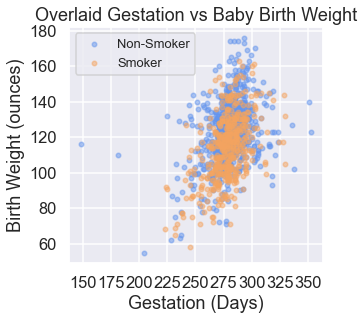

In [29]:
params = {'legend.fontsize': 20,
          'legend.handlelength': 2}
plt.rcParams.update(params)
fig, axes = plt.subplots(2, 2, figsize = (10, 10))

"""axes[0][0].set_title('Non-smoking Mothers\' Gestation vs Baby Birth Weight')
no_smoke.plot(kind = 'scatter', x = 'gestation', y = 'bwt', ax = axes[0][0], xticks = (range(150, 375, 25)), yticks = (range(60, 190, 20)))
axes[0][0].set_xlabel('Gestation (Days)')
axes[0][0].set_ylabel('Birth Weight (ounces)')

axes[0][1].set_title('Smoking Mothers\' Gestation vs Baby Birth Weight')
smoke.plot(kind = 'scatter', x = 'gestation', y = 'bwt', ax = axes[0][1], xticks = (range(150, 375, 25)), yticks = (range(60, 190, 20)))
axes[0][1].set_xlabel('Gestation (Days)')
axes[0][1].set_ylabel('Birth Weight (ounces)')"""

axes[1][0].set_title('Overlaid Gestation vs Baby Birth Weight')
no_smoke.plot(kind = 'scatter', x = 'gestation', y = 'bwt', ax = axes[1][0], xticks = (range(150, 375, 25)), yticks = (range(60, 190, 20)), color ='cornflowerblue',alpha =.5 )
smoke.plot(kind = 'scatter', x = 'gestation', y = 'bwt', ax = axes[1][0], xticks = (range(150, 375, 25)), yticks = (range(60, 190, 20)),color ='sandybrown', alpha =.5)
axes[1][0].set_xlabel('Gestation (Days)')
axes[1][0].set_ylabel('Birth Weight (ounces)')
axes[1][0].legend(['Non-Smoker','Smoker'], prop={'size': 13})

axes[1, 1].remove()
axes[0, 1].remove()
axes[0, 0].remove()
plt.subplots_adjust(hspace=0.3)

plt.show()

In the scatter plot above, we see the plot of gestation vs birth weight. We see that as we get to around 275 days, the birth weight born to non-smoking mothers is greater than that of smoking mothers. 

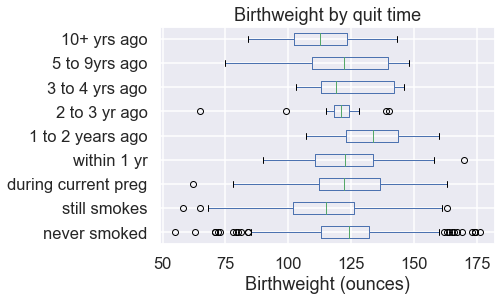

In [459]:
s = bdf.groupby('time')['bwt'].apply(np.array).rename({0:'never smoked', 1:'still smokes', 2:'during current preg', 3:'within 1 yr', 4:'1 to 2 years ago', 5: '2 to 3 yr ago', 6: '3 to 4 yrs ago', 7:'5 to 9yrs ago', 8:'10+ yrs ago'})
g = s.apply(lambda x:pd.Series(x)).T.boxplot(vert=False)
g.set_xlabel("Birthweight (ounces)")
g.set_title("Birthweight by quit time")
plt.show()

This box and whisker shows the median birthweight appears to be roughly the same across the represented groups, but there seems to be quite a few outliers for mothers who quit smoking 2 to 3 years ago and mothers who never smoked.

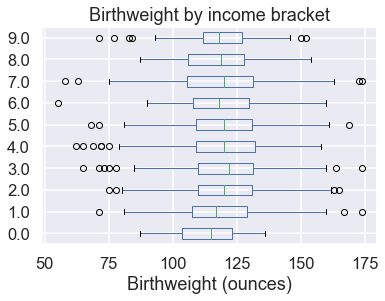

In [460]:
s = bdf.groupby('inc')['bwt'].apply(np.array)
g = s.apply(lambda x:pd.Series(x)).T.boxplot(vert = False)
g.set_xlabel('Birthweight (ounces)')
g.set_title('Birthweight by income bracket')
plt.show()

This graph seems to show an equivalent median of birth weight across income brackets, but it looks like the IQR is lowest in the top income bracket.

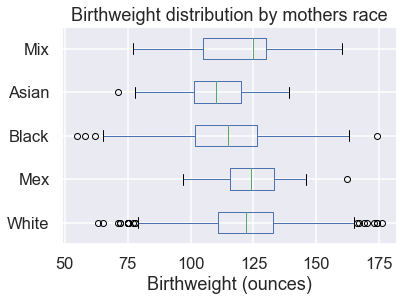

In [461]:
s = bdf.groupby('race')['bwt'].apply(np.array).rename({0:'White', 1:'Mex', 2:'Black', 3:'Asian', 4:'Mix'})
g = s.apply(lambda x:pd.Series(x)).T.boxplot(vert = False)
g.set_xlabel('Birthweight (ounces)')
g.set_title('Birthweight distribution by mothers race')
plt.show()

This plot clearly shows there are many more white mothers in the data than any other race, and their median birthweight looks to be roughly 120 ounces.

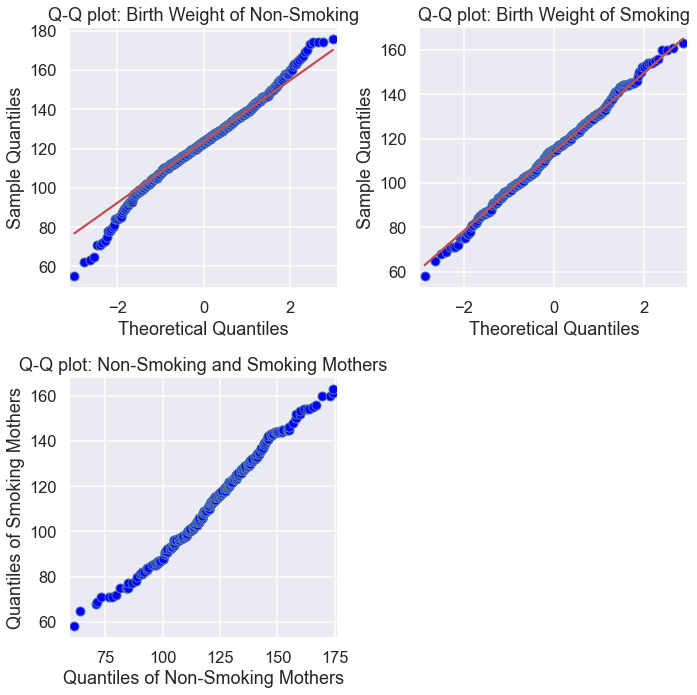

In [36]:
fig, axes = plt.subplots(2, 2, figsize = (10, 10))

axes[0][0].set_title('Q-Q plot: Birth Weight of Non-Smoking')
sm.qqplot(no_smoke['bwt'], line = 'q', ax = axes[0][0])

axes[0][1].set_title('Q-Q plot: Birth Weight of Smoking')
sm.qqplot(smoke['bwt'], line = 'q', ax = axes[0][1])


pp_x = sm.ProbPlot(no_smoke['bwt'])
pp_y = sm.ProbPlot(smoke['bwt'])
qqplot_2samples(pp_y, pp_x, ax = axes[1][0])
axes[1][0].set_title('Q-Q plot: Non-Smoking and Smoking Mothers')
axes[1][0].set_xlabel('Quantiles of Non-Smoking Mothers')
axes[1][0].set_ylabel('Quantiles of Smoking Mothers')

axes[1, 1].remove()
plt.tight_layout()
plt.show()


Above, we see that the quantile-quantile plot (qq plot) for non-smoking mothers is curved at the left and right ends. Hence, we hypothesize that the data departures from a normal distribution. On the other hand, the qq plot for the smoking mothers group is fairly straight. Hence, we believe that the data came from a normal distribution. 


In the bottom plot is the quartiles of both groups against each other. Because the slope is not 1, we are unable to conclude that the two distributions are identical. Furthermore, the left tail of the qq plot is more spread out than the right tail which means that the data does not increase as quickly as it decreases. 


Kutorsis for each Variables:

In [463]:
def simulation_study(series):
    kurtosis_temp = np.array([])
    for i in np.arange(1000):
        shuffle = np.random.normal(0,1,len(series))
        kurtosis = scipy.stats.kurtosis(shuffle,fisher = False) 
        kurtosis_temp = np.append(kurtosis_temp, kurtosis)
    return kurtosis_temp

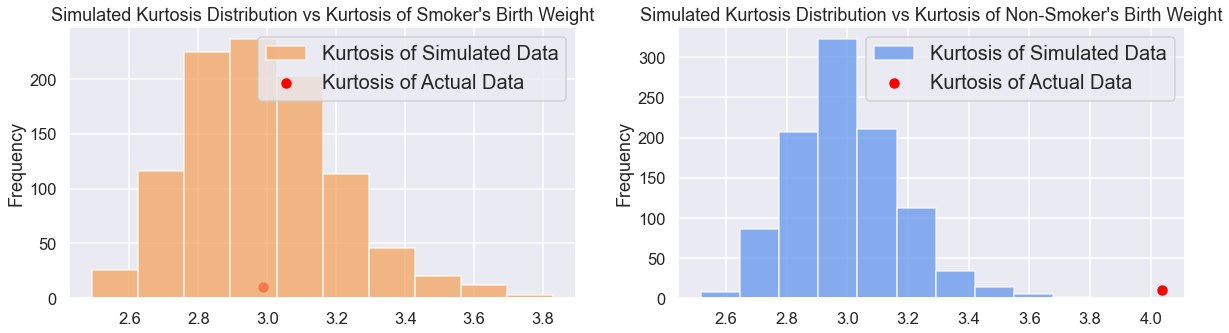

In [464]:
fig, axes = plt.subplots(1, 2, figsize = (20,5))

observed_smoke_kurtosis = scipy.stats.kurtosis(smoke.get('bwt'), fisher = False)
axes[0].set_title('Simulated Kurtosis Distribution vs Kurtosis of Smoker\'s Birth Weight') 
kdf_smoke = pd.DataFrame().assign(smoker_kurtosis = simulation_study(smoke.get('bwt')))
kdf_smoke.plot(kind = 'hist', ax = axes[0], color ='sandybrown', alpha = 0.75)
axes[0].scatter(observed_smoke_kurtosis, 10, color= 'red', s= 80)
axes[0].legend(['Kurtosis of Simulated Data', 'Kurtosis of Actual Data'])

observed_nosmoke_kurtosis = scipy.stats.kurtosis(no_smoke.get('bwt'),fisher = False) 
axes[1].set_title('Simulated Kurtosis Distribution vs Kurtosis of Non-Smoker\'s Birth Weight')
kdf_smoke = pd.DataFrame().assign(nonsmoker_kurtosis = simulation_study(no_smoke.get('bwt')))
kdf_smoke.plot(kind = 'hist', ax = axes[1], color = 'cornflowerblue', alpha = 0.75)
axes[1].scatter(observed_nosmoke_kurtosis, 10, color= 'red', s= 80)
axes[1].legend(['Kurtosis of Simulated Data', 'Kurtosis of Actual Data'])


plt.show()

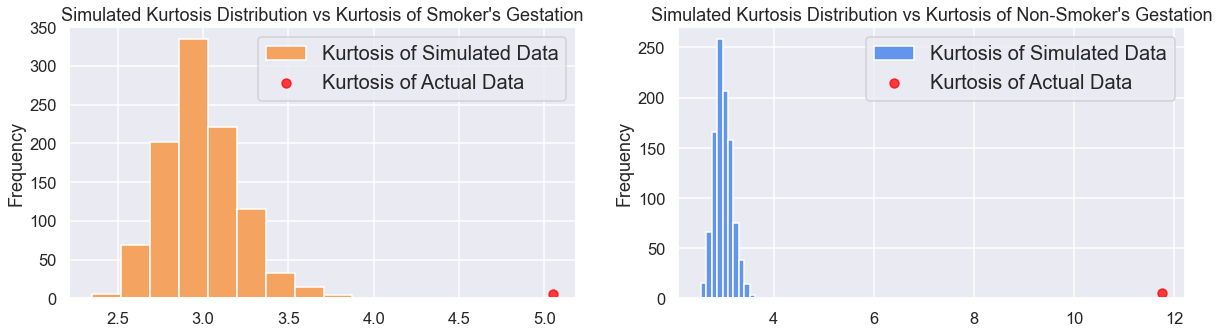

In [465]:
fig, axes = plt.subplots(1, 2, figsize = (20,5))

observed_smoke_kurtosis = scipy.stats.kurtosis(smoke['gestation'].dropna(),fisher = False)
axes[0].set_title('Simulated Kurtosis Distribution vs Kurtosis of Smoker\'s Gestation') 
kdf_smoke = pd.DataFrame().assign(smoker_kurtosis = simulation_study(smoke.get('gestation')))
kdf_smoke.plot(kind = 'hist', ax = axes[0], color ='sandybrown')
axes[0].scatter( observed_smoke_kurtosis, 5, color= 'red', s= 80, alpha = 0.75)
axes[0].legend(['Kurtosis of Simulated Data', 'Kurtosis of Actual Data'])

observed_nosmoke_kurtosis = scipy.stats.kurtosis(no_smoke['gestation'].dropna(),fisher = False) 
axes[1].set_title('Simulated Kurtosis Distribution vs Kurtosis of Non-Smoker\'s Gestation')
kdf_smoke = pd.DataFrame().assign(nonsmoker_kurtosis = simulation_study(no_smoke.get('gestation')))
kdf_smoke.plot(kind = 'hist', ax = axes[1], color = 'cornflowerblue')
axes[1].scatter( observed_nosmoke_kurtosis, 5, color= 'red', s= 80, alpha = 0.75)
axes[1].legend(['Kurtosis of Simulated Data', 'Kurtosis of Actual Data'])


plt.show()

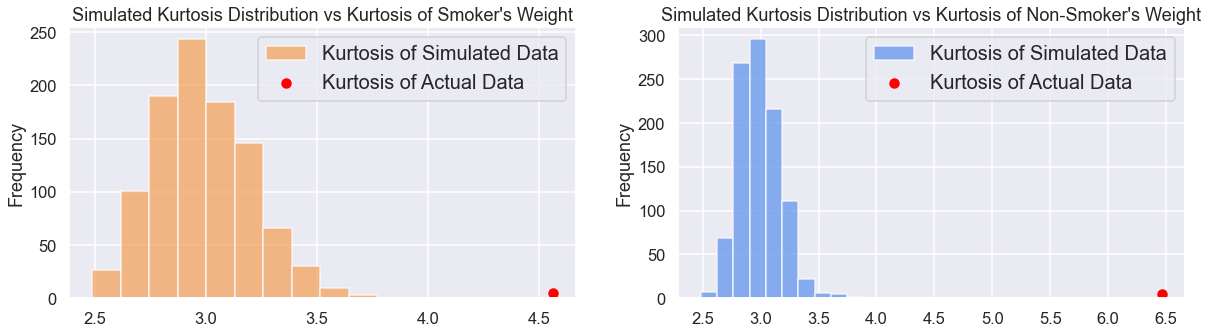

In [466]:
fig, axes = plt.subplots(1, 2, figsize = (20,5))

observed_smoke_kurtosis = scipy.stats.kurtosis(smoke['weight'].dropna(), fisher = False)
axes[0].set_title('Simulated Kurtosis Distribution vs Kurtosis of Smoker\'s Weight') 
kdf_smoke = pd.DataFrame().assign(smoker_kurtosis = simulation_study(smoke.get('weight')))
kdf_smoke.plot(kind = 'hist', ax = axes[0], color ='sandybrown', alpha = 0.75)
axes[0].scatter( observed_smoke_kurtosis, 5, color= 'red', s= 80)
axes[0].legend(['Kurtosis of Simulated Data', 'Kurtosis of Actual Data'])

observed_nosmoke_kurtosis = scipy.stats.kurtosis(no_smoke['weight'].dropna(), fisher = False) 
axes[1].set_title('Simulated Kurtosis Distribution vs Kurtosis of Non-Smoker\'s Weight')
kdf_smoke = pd.DataFrame().assign(nonsmoker_kurtosis = simulation_study(no_smoke.get('weight')))
kdf_smoke.plot(kind = 'hist', ax = axes[1], color = 'cornflowerblue', alpha = 0.75)
axes[1].scatter( observed_nosmoke_kurtosis, 5, color= 'red', s= 80)
axes[1].legend(['Kurtosis of Simulated Data', 'Kurtosis of Actual Data'])



plt.show()

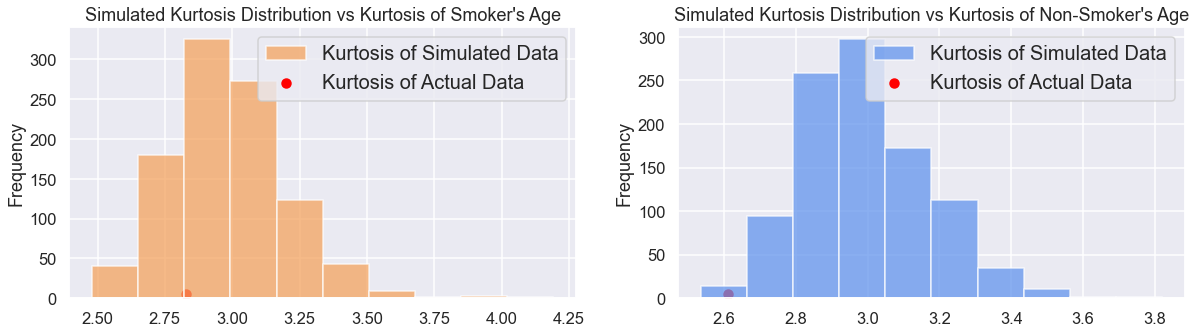

In [467]:
fig, axes = plt.subplots(1, 2, figsize = (20,5))

observed_smoke_kurtosis = scipy.stats.kurtosis(smoke['age'].dropna(),fisher = False)
axes[0].set_title('Simulated Kurtosis Distribution vs Kurtosis of Smoker\'s Age') 
kdf_smoke = pd.DataFrame().assign(smoker_kurtosis = simulation_study(smoke.get('age')))
kdf_smoke.plot(kind = 'hist', ax = axes[0], color ='sandybrown', alpha = 0.75)
axes[0].scatter( observed_smoke_kurtosis, 5, color= 'red', s= 80)
axes[0].legend(['Kurtosis of Simulated Data', 'Kurtosis of Actual Data'])

observed_nosmoke_kurtosis = scipy.stats.kurtosis(no_smoke['age'].dropna(),fisher = False) 
axes[1].set_title('Simulated Kurtosis Distribution vs Kurtosis of Non-Smoker\'s Age')
kdf_smoke = pd.DataFrame().assign(nonsmoker_kurtosis = simulation_study(no_smoke.get('age')))
kdf_smoke.plot(kind = 'hist', ax = axes[1], color = 'cornflowerblue', alpha = 0.75)
axes[1].scatter( observed_nosmoke_kurtosis, 5, color= 'red', s= 80)
axes[1].legend(['Kurtosis of Simulated Data', 'Kurtosis of Actual Data'])


plt.show()

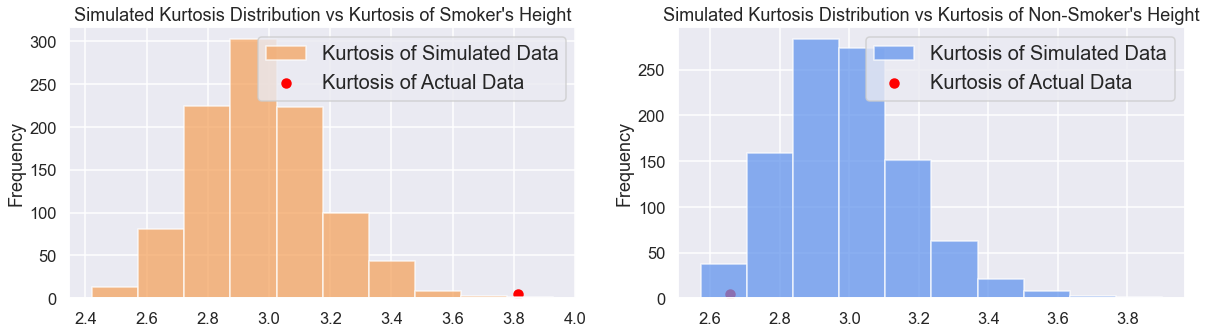

In [468]:
fig, axes = plt.subplots(1, 2, figsize = (20,5))

observed_smoke_kurtosis = scipy.stats.kurtosis(smoke['height'].dropna(),fisher = False)
axes[0].set_title('Simulated Kurtosis Distribution vs Kurtosis of Smoker\'s Height') 
kdf_smoke = pd.DataFrame().assign(smoker_kurtosis = simulation_study(smoke.get('height')))
kdf_smoke.plot(kind = 'hist', ax = axes[0], color ='sandybrown', alpha = 0.75)
axes[0].scatter( observed_smoke_kurtosis, 5, color= 'red', s= 80)
axes[0].legend(['Kurtosis of Simulated Data', 'Kurtosis of Actual Data'])

observed_nosmoke_kurtosis = scipy.stats.kurtosis(no_smoke['height'].dropna(),fisher = False) 
axes[1].set_title('Simulated Kurtosis Distribution vs Kurtosis of Non-Smoker\'s Height')
kdf_smoke = pd.DataFrame().assign(nonsmoker_kurtosis = simulation_study(no_smoke.get('height')))
kdf_smoke.plot(kind = 'hist', ax = axes[1], color = 'cornflowerblue', alpha = 0.75)
axes[1].scatter( observed_nosmoke_kurtosis, 5, color= 'red', s= 80)
axes[1].legend(['Kurtosis of Simulated Data', 'Kurtosis of Actual Data'])


plt.show()

Above, we have plotted the distribution of kurtosis coefficients from normally distributed data against the kurtosis coefficient of the actual data. 

Simulating 1000 times, each with a sample size depending on the number of observations in our actual data, the distribution of the kurtosis coefficients is approximately normal. 

With a null hypothesis of our data distribution having a normal distribution, we see above that only in two out of the ten histograms, the birth weight and height of the smokers' is approximately normal. As for the other eight distributions, because the kurtosis coefficient of the actual data is far from the center of the distribution of simulated kurtosis coefficients, we are unable to conclude that these distributions are normal. 

## Comparing Frequency

In [469]:
temp = []
for i in range(88, 145, 8): #from 3.5 pounds (56 ounces) to 9 pounds (144 ounces) increasing by 0.5 pounds (8 ounces) each time
    low_bwt = i
    nosmoke_low = len(no_smoke[no_smoke['bwt'] < low_bwt])
    smoke_low = len(smoke[smoke['bwt'] < low_bwt])
    
    ci_low_ns, ci_up_ns = proportion_confint(nosmoke_low, len(no_smoke['bwt'].dropna()), alpha=0.05, method='normal')
    ci_low_s, ci_up_s = proportion_confint(smoke_low, len(smoke['bwt'].dropna()), alpha=0.05, method='normal')
    
    ci_ns = '(' + str(round(ci_low_ns, 3)) + ', ' + str(round(ci_up_ns, 3)) + ')'
    ci_s = '(' + str(round(ci_low_s, 3)) + ', ' + str(round(ci_up_s, 3)) + ')'
    temp.append([low_bwt, nosmoke_low, smoke_low, round(nosmoke_low/len(no_smoke['bwt'].dropna()), 3), 
                 round(smoke_low/len(smoke['bwt'].dropna()), 3), ci_ns, ci_s])

freq = pd.DataFrame(temp, columns = ['Low Birth Weight Threshold (Ounces)', 'Non-smoking Count (Out of 742)', 
                                     'Smoking Count (Out of 484)', 'Non-smoking Percentage', 
                                     'Smoking Percentage', 'Non-Smoking Confidence Interval', 'Smoking Confidence Interval'])
freq


,Low Birth Weight Threshold (Ounces),Non-smoking Count (Out of 742),Smoking Count (Out of 484),Non-smoking Percentage,Smoking Percentage,Non-Smoking Confidence Interval,Smoking Confidence Interval
0,88,22,36,0.0300,0.0740,"(0.017, 0.042)","(0.051, 0.098)"
1,96,37,65,0.0500,0.1340,"(0.034, 0.066)","(0.104, 0.165)"
2,104,82,142,0.1110,0.2930,"(0.088, 0.133)","(0.253, 0.334)"
3,112,163,207,0.2200,0.4280,"(0.19, 0.249)","(0.384, 0.472)"
4,120,298,302,0.4020,0.6240,"(0.366, 0.437)","(0.581, 0.667)"
5,128,451,375,0.6080,0.7750,"(0.573, 0.643)","(0.738, 0.812)"
6,136,578,428,0.7790,0.8840,"(0.749, 0.809)","(0.856, 0.913)"
7,144,664,454,0.8950,0.9380,"(0.873, 0.917)","(0.917, 0.959)"


Above, we are comparing the frequency of low birth weights among non-smoking and smoking mothers using a varying threshold for low birth weights. From our background research, it has been noted that a baby born on term (a gestation period of around 40 weeks) that weighs less than 5.5 pounds or 88 ounces is considered to have low birth weight. Starting from 88 ounces, we see the percentage of low birth weight for non-smoking mothers is only 0.03%. For smoking mothers, we see that this percentage doubles to 0.074%. Continuing increases by 8 ounces each time, we see that the percentage of low weight babies born to smoking mothers is consistently greater than that of non-smoking mothers. 


The last two columns are the confidence intervals for each low birth weight threshold. Using an alpha of 0.05, we are 95% confident that the true population proportion of babies born with low birth weight for non-smoking and smoking mothers is contained within the interval.

## Compare numerical, graphical, and frequency parts

Comparing the three types of methods used, we see that just within the graphical section, there are a few contradictions. Each method will give us different information helping us answer the different questions. Looking at the histograms of each variable, we hypothesized that most of the distributions, with the exception of weight, were approximately normal. However, when performing the quantile-quantile plot for birth weight, we see that the non-smoking group deviates from the normal distribution a little. Additionally, through the kurtosis simulations, we see that only the smokers group birth weight and age distributions are normal. Our numerical and incidence sections agree with each other, in the sense that there is a difference in birth weights. The hypothesis notes that there is a significant difference in the mean birth weights and our population proportion confidence interval confirms that the proportion of low birth weight babies in the smoking group is consistently greater than those of the non-smoking group. 

## Summarizing Findings

From the numerical summaries, we immediately see that there is a significant difference between the baby birth weight born to non-smoking and smoking mothers. Continuing with hypothesis testing for the remaining variables, we found that there was a significant difference between the weight, gestation, and age of both groups, with non-smoking mothers being heavier, older, and having a longer gestation period. This mimics that of the findings presented by the study of smoking mothers having a lower body weight and the mother’s nutritional intake, which both affect the birth weight.

Our data did not show a significant difference between the heights of the smoking and non-smoking groups. However, we do not have the data or analysis to show if height is a contributing factor to a child’s birth weight. Furthermore, with the comparison of incidence between the two groups, we see the proportion of low birth weight babies born to smoking mothers is constantly higher than that of non-smoking mothers. Even after raising the threshold for what is considered as low birth weight, our analysis does not change by much. Up to 112 ounces, the proportion of low birth weight babies born to smoking mothers is around that of their counterparts. 

From this analysis, we are able to conclude that within our data, there is a correlation between low birth weight and smoking. However, we are unable to specifically conclude that low birth weight is directly caused by smoking. The reason for this is because other factors might play a role therefore we can’t say that low birth weight is directly caused by smoking. 

## Independent Questions

In [470]:
pd.options.display.float_format = '{:,.4f}'.format

In [473]:
def t_test_mean(sig_level, feature, indic1, indic2):
    """
    input significance level, feature to examine and 
    two indicators, prints pval & whether we accept or reject
    the null hypothesis (that the observed means can plausibly 
    be drawn from the same population)
    Automatically determines whether to use z-test or ttest based 
    upon the size of the samples  given, with > 30 being ztest
    """
    pop_1 = bdf[(bdf[feature] == indic1)]['bwt']
    pop_2 = bdf[(bdf[feature] == indic2)]['bwt']
    if (len(pop_1) >  30) & (len(pop_2) > 30):
        ty = 'ztest'
        stat, pval = stests.ztest(pop_1, pop_2, value = 0, alternative = 'two-sided')
    else:
        ty = 'ttest'
        stat, pval = ttest_ind(pop_1, pop_2)
    sig_level = sig_level
    #print(pval)
    if pval < sig_level:
        Conclusion = 'Reject'
    else:
        Conclusion = 'Fail to reject'
    return {'type': ty, "pval" : pval, 'Conclusion' : Conclusion, 'Test Statistic': stat}

### Among mothers who quit smoking, does the length of time between quitting and birth impact the birth weight relative to mothers who still smoke? Is this effect statistically significant at the alpha = .05 level?

$H_0$ : When compared to mothers who still smoke, mean birth weights are equal across time periods of when the mom quit smoking. That is, given two sample means  $\mu_0 - \mu_1 = 0$

$H_1$: The two sample means are not equal. That is , $\mu_0 - \mu_1 \neq 0$


In [474]:
smoker_status = {1:'still smokes', 2:'during current preg', 3:'within 1 yr', 4:'1 to 2 years ago', 5: '2 to 3 yr ago', 6: '3 to 4 yrs ago', 7:'5 to 9yrs ago', 8:'10+yrs ago'}
outs = {}
for key in smoker_status.keys():
    outs[smoker_status[key]] = t_test_mean(.05, 'time', 1, key)
pd.DataFrame(outs)

,still smokes,during current preg,within 1 yr,1 to 2 years ago,2 to 3 yr ago,3 to 4 yrs ago,5 to 9yrs ago,10+yrs ago
type,ztest,ztest,ttest,ttest,ttest,ttest,ttest,ttest
pval,1.0000,0.0000,0.0017,0.0000,0.4925,0.1007,0.1829,0.8816
conclusion,Fail to reject,Reject,Reject,Reject,Fail to reject,Fail to reject,Fail to reject,Fail to reject
Test Statistic,0.0000,-4.4306,-3.1487,-4.9724,-0.6869,-1.6446,-1.3337,0.1490


This question is about differences in birth weights between mothers who still smoke versus mothers who used to smoke but quit. To answer this question, I wrote a difference of means hypothesis test that looks at the difference between mean birth weight across still smoking mothers and each time bracket of mothers who quit smoking. As far as test selection, I used z-tests when both groups represented were sufficiently large (in this case >30), and t-tests when the samples were too small for z-tests. This choice was made because the tails of the student’s t distribution are fatter, making the burden of proof greater than the normal distribution. Because some of the time intervals of having quit smoking contain so few mothers, it makes sense to use a test that is less likely to conclude, as the sample drawn is less likely to be representative of the population. The results of these tests show us some non-intuitive conclusions. More specifically, the mothers who quit most recently (during current, within 1 year & 1 to 2 years) had statistically significant differences in mean birth weight relative to the mothers who did not quit, but no such difference existed for the mothers who quit a longer time ago (from 2 to 10+ years ago). I think this difference is reflective of how little data there is in each of these brackets, but without more data this is only a baseless suspicion.


### Does parental income impact birth weight? In particular, are there significant differences between the highest income bracket (>\$15000/year), and the other brackets? Is this effect statistically significant at the alpha = .05 level?


$H_0$ : When compared to the highest bracket, mean birth weights are equal across the income brackets. That is, given two sample means  $\mu_0 - \mu_1 = 0$, where $\mu_0$ is mean birth weight in the highest income bracket


$H_1$: The two sample means are not equal. That is , $\mu_0 - \mu_1 \neq 0$


In [475]:
outs = {}
for i in bdf['inc'].unique():
    if ~np.isnan(i):
        outs[i] = t_test_mean(.05, 'inc', 9, i)
pd.DataFrame(outs).sort_index(axis = 1)

,0.0000,1.0000,2.0000,3.0000,4.0000,5.0000,6.0000,7.0000,8.0000,9.0000
type,ttest,ttest,ttest,ttest,ttest,ttest,ttest,ttest,ttest,ttest
pval,0.6432,0.4820,0.2086,0.2099,0.4390,0.3317,0.4849,0.4662,0.5732,1.0000
conclusion,Fail to reject,Fail to reject,Fail to reject,Fail to reject,Fail to reject,Fail to reject,Fail to reject,Fail to reject,Fail to reject,Fail to reject
Test Statistic,0.4659,-0.7043,-1.2614,-1.2577,-0.7758,-0.9738,-0.7013,-0.7304,-0.5674,0.0000


This question is about differences in birth weights between income levels. To answer this question, I wrote a difference of means hypothesis test that looks at the difference between mean birth weight across the highest income bracket and each lower income bracket of mothers. As far as test selection, I used t-tests because the samples were too small for z-tests. This choice was made because the tails of the student’s t distribution are fatter, making the burden of proof greater than the normal distribution. Because each of the income brackets only has limited occurrence in the data (all less than 30 samples each), it makes sense to use a test that is less likely to conclude, as the sample drawn may not be representative of the population.

Every single one of the income brackets had fewer than 30 occurrences in the data set, so t-tests were used for all of these comparisons. None of them were statistically significant, which seems to imply that the income of the parents has little impact on the birth weight of babies.


### Does mother’s race impact birth weight? In particular, when comparing white mothers to the other represented races, is there a difference in mean birth weights? Is this effect statistically significant at the alpha = .05 level?

$H_0$ : When compared to white mothers, mean birth weights are equal across mother's ethnicities. That is, given two sample means  $\mu_0 - \mu_1 = 0$, where $\mu_0$ is white mothers

$H_1$: The two sample means are not equal. That is , $\mu_0 - \mu_1 \neq 0$


In [476]:
rstr = {0:'White', 1:'Mex', 2:'Black', 3:'Asian', 4:'Mix'}
outs = {}
for i in bdf['race'].unique():
    if ~np.isnan(i):
        outs[rstr[i]] = t_test_mean(.05, 'race', 0, i)
pd.DataFrame(outs)

,Asian,White,Black,Mix,Mex
type,ztest,ztest,ztest,ttest,ztest
pval,0.0000,1.0000,0.0000,0.6095,0.3770
conclusion,Reject,Fail to reject,Reject,Fail to reject,Fail to reject
Test Statistic,4.1171,0.0000,6.4412,0.5109,-0.8835


This question is about differences in birth weights between mothers' race. To answer this question, I wrote a difference of means hypothesis test that looks at the difference between mean birth weight across white mothers and each other race of mothers represented in the sample. As far as test selection, I used z-tests when both groups represented were sufficiently large (in this case >30), and t-tests when the samples were too small for z-tests. This choice was made because the tails of the student’s t distribution are fatter, making the burden of proof greater than the normal distribution. Because mix is the only race with limited occurrence in the data (less than 30 samples each), it makes sense to use a test that is less likely to conclude, as the sample drawn may not be representative of the population.

This test showed significant baby weight differences between Asian and White & Black and White. This might be due to a confounding factor, for example if Black mothers are more likely to be smokers, then this effect could be a result of that higher incidence of smoking rather than an impact of the race itself. 


# Theory

## Histograms
Histograms are estimators of the probability density function for a given distribution. Histograms consist of bins that count the number of observations within each interval. The number of bins must be predetermined. 
$$\hat{f}_x (a) = \frac{1}{n} \left( \text{# of observations within} B_l \right) \times \left( \frac{1}{\text{length of bin} B_l} \right)$$
where $a$ is a specific location in the distribution and $B_l$ is a bin that contains $a$.

Histograms have lower bias the more number of bins are used.
Histograms provide useful information about the spread of the data and can be used to identify potential outliers, whether the underlying distribution is unimodal/bimodal or symmetric/asymmetric, and what proportion of the distribution lies above or below a certain value.

## Box Plots
Box plots graphically represent data through the use of boxes and whiskers. In a box, the box itself represents the middle 50% of the data, and the lines extending from it (whiskers) extend to 1.5 times the interquartile range from the upper and lower quartiles. Potential outliers are also defined by dots extending past the whiskers.
The information provided by box plots can be used to identify potential outliers, skew, quartiles, and the mean of the data.

## Quantile-Quantile Plots
Quantile-quantile plots (qq plots) are useful when assessing whether our two groups of data came from the same distribution and whether the data came from normal distribution. In our project, we had used two different qq plots, comparing a single group with the normal distribution and against each other. In plotting a single group, a straight line is plotted if the data follows a normal distribution. In the comparison of both groups, a straight line with a slope of 1 and intercept of 0 indicates that the two groups have identical distribution. Moreover, a straight line with slope different than 1 and intercept other than 0 may indicate that the two groups have a common distribution but differ in mean or standard deviation. 

## Kurtosis
In addition to the quantile-quantile plots, we carried out a kurtosis simulation, comparing our data’s kurtosis coefficient with a histogram of kurtosis coefficients from simulated normal data in order to check for the normality of the variables. To accomplish this, we generated a number of data points equal to that of our data from a normal distribution, and repeated 1000 times, each time calculating the kurtosis coefficient for each sample. We then plotted a histogram of the 1000 simulations and compared our actual data’s kurtosis coefficient against it. Typically, the kurtosis coefficient of a normal distribution has a value of 3. Hence, the histogram of simulated kurtosis coefficients is centered around 3. If a kurtosis coefficient is not close to the center of the histogram, i.e the value of 3, we conclude that the data did not come from normal distribution. 

## Scatterplots
Scatterplots show values for two numerical variables of a data set. We can use them for examining the relationship between two variables in question, and ask if they might be dependent or independent. They may also be helpful in viewing the general spread of the data along two variables and seeing if possible clusters exist.

## Hypothesis Testing
We used difference of means hypothesis tests quite a bit in this project. The null hypothesis is that the two groups have no difference in means, and the alternative is that there is. This is a useful method for comparing distributions to see if they can plausibly be the same or not.


# References

Albanes, D., Jones, D. Y., Micozzi, M. S., & Mattson, M. E. (1987). Associations between smoking and body weight in the US population: Analysis of NHANES II. *American Journal of Public Health, 77(4)*, 439-444. doi:10.2105/ajph.77.4.439

J Yerushalmy, The relationship of parents' cigarette smoking to outcome of pregnancy—implications as to the problem of inferring causation from observed associations, *International Journal of Epidemiology*, Volume 43, Issue 5, October 2014, Pages 1355–1366, https://doi.org/10.1093/ije/dyu160

Ludwig, D., & Currie, J. (2010, September 18). The association between pregnancy weight gain and birthweight: A within-family comparison. Retrieved January 21, 2021, from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2974327/#:~:text=We%20observed%20that%20every%20additional,weight%20by%20approximately%20200%20g

Mathews, T. J., Menacker, F., & MacDorman, M. F. (2003). Infant mortality statistics from the 2001 period linked birth/infant death data set. *National vital statistics reports*, 52(2), 1-28.

Wilcox, A. J., & Skjaerven, R. (1992). Birth weight and perinatal mortality: the effect of gestational age. *American journal of public health*, 82(3), 378-382.

Williams, N. A., & Buss, K. A. (2008). *Short and long-term effects of birth weight and neonatal medical complications on children's emotional and behavioral outcomes* (Unpublished doctoral dissertation). University of Missouri-Columbia.


# Contributions

- Kasen Teoh
    - In this project, I had written the introduction and background of the report. Additionally, I cleaned the babies..txt and numerical summarized the data for both groups, non-smoking and smoking. I also implemented the two independent samples mean hypothesis test, along with the quantile-quantile plots comparing against normality and against each other and the frequency comparison with confidence intervals. Wrote the theory for quantile-quantile plots, compared the three methods, and summarized findings. 
- Chung En Pan
    - Wrote the data and the kurtosis part of the report. 
    - Implemented the graphical summaries histogram, scatterplot (Overlaid Baby Birth Weight Distribution, Overlaid Gestation Distribution, Overlaid Height Distribution, Overlaid Mothers' Weight Distribution,Overlaid Gestation vs Baby Birth Weight). 
    - Performed simulation study to test normality of kurtosis of each variable (Simulated Kurtosis Distribution vs Kurtosis of babies’ Birth Weight, Simulated Kurtosis Distribution vs Kurtosis of Gestation,Simulated Kurtosis Distribution vs Kurtosis of Mothers’ Weight,Simulated Kurtosis Distribution vs Kurtosis of Mothers’ Age, Simulated Kurtosis Distribution vs Kurtosis of Mothers’ Height). 
- Nathan Fallahi
    - I contributed to the background section of the report, as well as the graphical summaries (specifically adding the box plots and adjusting histograms). I wrote a portion of the summary of our findings and also contributed to the Theory section, writing the justification for our use of histograms, box plots, and scatter plots. 
- Shaheen Daneshvar
- Parsa Ganjooi
    - I helped add information to both the introduction and the background of the report. I added information to the Summarize finding section. Used the babies23 data set to make qq plots, histograms, and box plots which helped answer the questions related to the report. I also helped out with the hypothesis testing for C, D, and E. 
- Eamon Jarrett-Mann
    - Implemented any cleaning, visualization or hypothesis testing involving the larger dataset (Babies23), DataFrame named ‘bdf’ (graphs: Birth Weight distribution by mothers race, Birthweight by income bracket, Birth Weight by quit time, Birth Weight distribution by mothers race, Birth Weight distribution by income bracket, Birth Weight distribution by smoking status) in addition to any summaries of these graphics.  Implemented the heatmap on the smaller dataset for correlation analysis. Wrote independent investigation questions with methods and implemented hypothesis tests & with conclusions.
